In [2]:
!rm -rf *
!git config --global user.name "Akhilez"
!git config --global user.email "akhild18@yahoo.com"
!git clone https://github.com/Akhilez/ml_gallery.git
%cd ml_gallery/ml_py

Cloning into 'ml_gallery'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (568/568), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 2095 (delta 342), reused 356 (delta 163), pack-reused 1527
Receiving objects: 100% (2095/2095), 11.77 MiB | 12.33 MiB/s, done.
Resolving deltas: 100% (1280/1280), done.
/content/ml_gallery/ml_py


In [3]:
import os
os.environ['SECRET_KEY'] = '1234'
%mkdir -p data/mnist/numbers

In [4]:
import torch
from torch.nn.functional import relu
from collections import namedtuple
import numpy as np
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
aug = MNISTAug()
dm = DataManager()
dm.load()
aug.max_objects = 10
aug.min_objects = 4

Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/train-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw


Extracting /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/ml_gallery/ml_py/data/mnist/numbers/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 10)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [8]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

[{'class': 1,
  'class_one_hot': tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'cx': 93.0,
  'cy': 33.0,
  'height': 48,
  'width': 38,
  'x1': 74,
  'x2': 112,
  'y1': 9,
  'y2': 57},
 {'class': 8,
  'class_one_hot': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  'cx': 29.5,
  'cy': 28.5,
  'height': 33,
  'width': 33,
  'x1': 13,
  'x2': 46,
  'y1': 12,
  'y2': 45},
 {'class': 4,
  'class_one_hot': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  'cx': 35.5,
  'cy': 56.5,
  'height': 45,
  'width': 45,
  'x1': 13,
  'x2': 58,
  'y1': 34,
  'y2': 79},
 {'class': 7,
  'class_one_hot': tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  'cx': 52.5,
  'cy': 96.5,
  'height': 15,
  'width': 15,
  'x1': 45,
  'x2': 60,
  'y1': 89,
  'y2': 104},
 {'class': 4,
  'class_one_hot': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  'cx': 101.0,
  'cy': 70.5,
  'height': 27,
  'width': 22,
  'x1': 90,
  'x2': 112,
  'y1': 57,
  'y2': 84}]

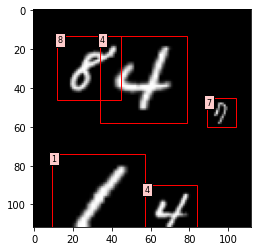

In [9]:
DataManager.plot_num(x_train[0].reshape((112, 112)), y_train[0])
y_train[0]

In [10]:
def to_one_hot(x, num_classes=10):
  b = np.zeros((len(x), num_classes), dtype=np.float32)
  b[np.arange(len(x)), x] = 1
  return b

In [11]:
# 14 * 14  = 196 anchor boxes
# side of each anchor box = 28

n_anchors = 14 * 14

anchor_grid_spacing = 8

anchor_centers = []
for i in range(14):
  anchor_row = []
  for j in range(14):
    anchor_row.append([
      j * anchor_grid_spacing + anchor_grid_spacing / 2,
      i * anchor_grid_spacing + anchor_grid_spacing / 2,
    ])
  anchor_centers.append(anchor_row)
anchor_centers = torch.tensor(anchor_centers).reshape((-1, 2))

In [12]:
def get_iou(anchor_center, bounding_box):

  boxA = [anchor_center[0]-14, anchor_center[1]-14, anchor_center[0]+14, anchor_center[1]+14]
  boxB = [bounding_box['x1'], bounding_box['y1'], bounding_box['x2'], bounding_box['y2']]

  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [23]:
def get_positive_box_index(anchor, bounding_boxes):
  max_iou, max_iou_index = 0, -1
  for bounding_i in range(len(bounding_boxes)):
    iou = get_iou(anchor, bounding_boxes[bounding_i])
    if iou > max_iou:
      max_iou = iou
      max_iou_index = bounding_i
  if max_iou > 0.4:
    return max_iou_index
  return -1

In [24]:
def get_positive_anchors(y_batch):
    """
    1. For Each item in the batch:
    2. For each anchor box:
    - For each bounding box:
        - Find the IoU.
    - Pick bounding box with highest IoU for that anchor.
    - # TODO: Pick the anchor with the highest IoU for that bounding box.
    - If highest IoU is < 0.3, then continue 1.
    # - Create the difference units for the anchor and the bounding box as y
    - Now add the anchor box and bounding box into a map.
    """
    positive_pairs = []
    for batch_i in range(len(y_batch)):
        positive_pairs_batch = []
        max_iou_b = {}
        max_iou_a = {}

        # ---------- The two loops --------------

        for anchor_i in range(len(anchor_centers)):
            for bb_i in range(len(y_batch[batch_i])):

                b_box = y_batch[batch_i][bb_i]
                a_box = anchor_centers[anchor_i]

                iou = get_iou(a_box, b_box)
                default_iou = {'iou': 0, 'bb_i': -1, 'ab_i': -1}

                # --------------- Find max IoUs ------------------

                if iou > max_iou_b.get(bb_i, default_iou)['iou']:
                    max_iou_b[bb_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

                if iou > 0.4 and iou > max_iou_a(anchor_i, default_iou)['iou']:
                    max_iou_a[anchor_i] = {
                        'iou': iou,
                        'bb_i': bb_i,
                        'ab_i': anchor_i
                    }

            # --------- Merge both max ious ----------------
            
            

        positive_pairs.append(positive_pairs_batch)
    return positive_pairs

In [25]:
positives = get_positive_anchors(y_test[:2])
for positive in positives:
  print(len(positive))
14 * 14

26
42


196

In [26]:
def get_fractional_difference(anchor, bounding_box):
  a_box = anchor
  b_box = bounding_box

  cx_d = (b_box['cx'] - a_box[0]) / 112
  cy_d = (b_box['cy'] - a_box[1]) / 112
  wd = (b_box['width'] - 28) / 112

  return cx_d, cy_d, wd

def get_units_from_diff(anchor, bounding_box):
  cx_d = bounding_box['cx'] * 112 + anchor[0]
  cy_d = bounding_box['cy'] * 112 + anchor[1]
  wd = bounding_box['width'] * 112 + 28

  return cx_d, cy_d, wd

In [27]:
def get_confidences(positive_pairs):
  confidences = torch.zeros((14 * 14), dtype=torch.int)
  for pair in positive_pairs:
    confidences[pair['anchor_index']] = 1
  return torch.tensor(to_one_hot(confidences.numpy(), 2)).reshape((-1))

In [34]:
def get_y_d(y):
  """
  Find all the positive anchor pairs.
  for each of y:
    for each pair in yi:
      find fractional difference in anchor and bounding box.
      append the fractional difference to the pair.
  """
  y_d = []
  positive_pairs = get_positive_anchors(y)
  for yi in range(len(y)):
    diffs = []
    for pair_i in range(len(y[yi])):
      pair = positive_pairs[yi][pair_i]
      anchor = anchor_centers[pair['anchor_index']]
      bounding_box = y[yi][pair['bounding_box_index']]
      cx_d, cy_d, wd = get_fractional_difference(anchor, bounding_box)
      diffs.append((cx_d, cy_d, wd, pair['anchor_index'], pair['bounding_box_index']))
    y_d.append(torch.tensor(diffs))
  return y_d

In [35]:
# y_train_d = get_y_d(y_train)
y_test_d = get_y_d(y_test)

In [36]:
y_test_d[0]

tensor([[-8.9286e-03,  7.1429e-02, -1.7857e-02,  4.8000e+01,  2.0000e+00],
        [ 6.2500e-02,  0.0000e+00, -1.7857e-02,  6.1000e+01,  2.0000e+00],
        [-8.9286e-03,  0.0000e+00, -1.7857e-02,  6.2000e+01,  2.0000e+00],
        [-8.0357e-02,  0.0000e+00, -1.7857e-02,  6.3000e+01,  2.0000e+00],
        [-8.9286e-03, -7.1429e-02, -1.7857e-02,  7.6000e+01,  2.0000e+00],
        [ 4.4643e-02,  2.6786e-02,  0.0000e+00,  1.1300e+02,  5.0000e+00]])

In [ ]:
class BoxPredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(4096, 1024)
    self.linear2 = torch.nn.Linear(1024, 3 * n_anchors)

  def forward(self, x):
    x = relu(self.linear1(x))
    x = torch.tanh(self.linear2(x))
    return x


class ConfidencePredictor(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(4096, 1024)
    self.linear2 = torch.nn.Linear(1024, 2 * n_anchors)

  def forward(self, x):
    x = relu(self.linear1(x))
    x = torch.nn.functional.softmax(self.linear2(x).reshape((-1, n_anchors, 2)), 2)
    return x


class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 112x112
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 56x56
        self.conv3 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 28x28
        self.conv4 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 14x14
        self.conv5 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)  # 7x7
        self.linear1 = torch.nn.Linear(25088, 4096)
        self.box_predictor = BoxPredictor()
        self.confidence_predictor = ConfidencePredictor()

    def forward(self, x):
        x = relu(self.conv1(x))  # 112
        x = relu(self.conv2(x))  # 56
        x = relu(self.conv3(x))  # 28
        x = relu(self.conv4(x))  # 14
        x = relu(self.conv5(x))  # 7
        x = torch.flatten(x, 1)
        x = relu(self.linear1(x))
        boxes = self.box_predictor(x)
        confidences = self.confidence_predictor(x)
        return boxes, confidences

model = DetectorV1().to(device)
optimizer = torch.optim.Adam(model.parameters())

Steps:
 - get the predictions.
 - Find the anchors which have >0.1 IoU -> +ve anchors
 - Find the matching bounding box for each +ve anchor
 - All +ve anchors are high confidence, rest are low.
 - What is the loss for -ve anchors?


 - For each of the positive anchors, Find loss and add it to the total loss.
 - Find loss of the confidences.
 - 


In [ ]:
epochs = 2
batch_size = 5

for epoch in range(epochs):
    
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_d_train[start_index:end_index]
        
        optimizer.zero_grad()

        y_hat = model(x_batch)

        for i in range(batch_size):
          y_diffs = y_batch[i]['diffs'].to(device)
          # Find the positive indices.
          # positive_indices = 

        positive_anchors = get_positive_anchors(y_hat, y_batch)

        loss = sum(sum((y_batch - y_hat)**2))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch}, loss={float(loss)}')